In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

# from dataprep.eda import create_report

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#-----------------------------------------------------------------------------------------
# FEATURE IMPORTANCE
#-----------------------------------------------------------------------------------------

def plot_feature_importance (estimator_object, X_train, y_train):

    model = estimator_object
    model.fit(X_train, y_train)  


    feature_importance = model.feature_importances_

    # Make importance relative to max_importance

    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(8, 18))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.keys()[sorted_idx])  #!!!!!

    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

    plt.show()

In [120]:
train_df = pd.read_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/train_df.csv')
transported = pd.read_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/transported.csv')
test_df = pd.read_csv('/Users/ssv/TestProj/ML/Spaceship_Titanic/datasets/test_df.csv')

transported = np.ravel(transported)
submission_df = pd.DataFrame(test_df.loc[:, 'PassengerId'])

KeyError: 'PassengerId'

## ------------------------------------------------------------------------------------------------------------

# MODEL


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [9]:
model = GradientBoostingClassifier()

In [10]:
default_params = model.get_params()

In [20]:
default_params

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [97]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


def evaluate(models):
    
    results, names = list(), list()
    for name, model in models.items():
        # evaluate the model
        scores = evaluate_model(model, train_df, transported)
        # store the results
        results.append(scores)
        names.append(name)
        # summarize the performance along the way
        print('>%s %.3f (%.3f) (%.3f)' % (name, mean(scores), np.max(scores), std(scores)))
    
    plt.boxplot(results, labels=names, showmeans=True)
    plt.show()
    
    
def get_models_estimators():
    
    models = {}
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n)
    return models
 

def get_models_subsample():
    
    models = {}
    # explore sample ratio from 10% to 100% in 10% increments
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingClassifier(subsample=i)
    return models


def get_models_max_features(column_count=20):
    
    models = {}
    max_features = list(range(0, column_count)) + ['sqrt', 'log2']
    
    for i in range(1,len(max_features)):
        models[str(i)] = GradientBoostingClassifier(max_features=max_features[i])
    
    return models


def get_models_learning_rate():
    
    models = {}
    # define learning rates to explore
    for i in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9, 1.0]:
        key = '%.4f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i)
    return models


def get_models_max_depth():
    
    models = {}
    # define max tree depths to explore between 1 and 10
    for i in range(1,11):
        models[str(i)] = GradientBoostingClassifier(max_depth=i)
        
    return models

def get_models_loss():
    
    models = {}
    loss = ['deviance', 'exponential']
    
    for i in loss:
        models[i] = GradientBoostingClassifier(loss=i)
        
    return models


def get_models_criterion():
    
    models = {}
    criterion = ['friedman_mse', 'squared_error']
    
    for i in criterion:
        models[i] = GradientBoostingClassifier(criterion=i)
        
    return models




>10 0.761 (0.771) (0.006)
>50 0.795 (0.804) (0.005)
>100 0.799 (0.805) (0.005)
>500 0.800 (0.808) (0.004)
>1000 0.796 (0.802) (0.004)


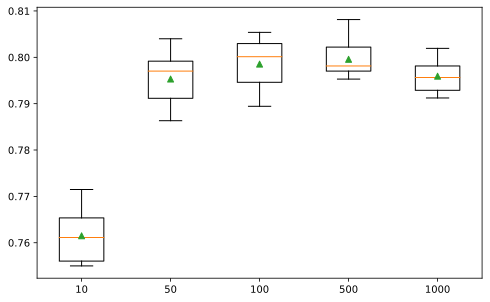

In [98]:
models = get_models_estimators()
evaluate(models)

>0.1 0.794 (0.801) (0.004)
>0.2 0.798 (0.805) (0.005)
>0.3 0.801 (0.810) (0.005)
>0.4 0.801 (0.809) (0.007)
>0.5 0.799 (0.811) (0.006)
>0.6 0.801 (0.810) (0.006)
>0.7 0.800 (0.810) (0.005)
>0.8 0.800 (0.808) (0.006)
>0.9 0.800 (0.807) (0.006)
>1.0 0.799 (0.805) (0.005)


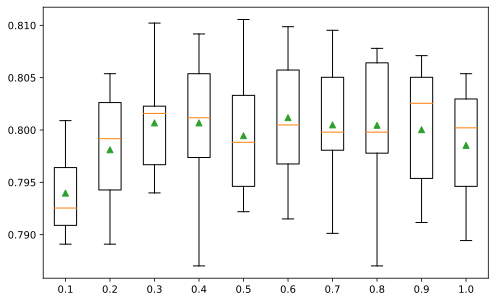

In [99]:
models = get_models_subsample()
evaluate(models)

>1 0.798 (0.810) (0.007)
>2 0.800 (0.811) (0.006)
>3 0.799 (0.809) (0.008)
>4 0.802 (0.810) (0.006)
>5 0.801 (0.809) (0.006)
>6 0.800 (0.809) (0.005)
>7 0.801 (0.809) (0.005)
>8 0.801 (0.811) (0.007)
>9 0.801 (0.809) (0.007)
>10 0.799 (0.806) (0.006)
>11 0.802 (0.811) (0.006)
>12 0.799 (0.808) (0.007)


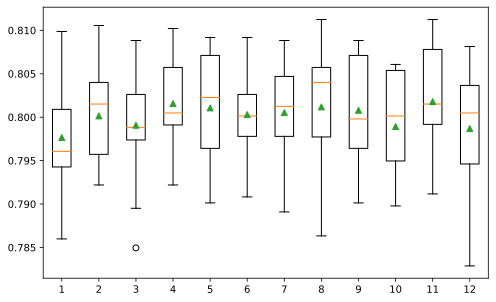

In [100]:
models = get_models_max_features(train_df.shape[1])
evaluate(models)

>0.0001 0.527 (0.611) (0.044)
>0.0010 0.758 (0.771) (0.007)
>0.0100 0.764 (0.773) (0.007)
>0.0500 0.796 (0.806) (0.006)
>0.1000 0.798 (0.805) (0.005)
>0.2000 0.799 (0.804) (0.005)
>0.3000 0.798 (0.806) (0.005)
>0.4000 0.793 (0.798) (0.004)
>0.5000 0.791 (0.800) (0.005)
>0.9000 0.780 (0.786) (0.005)
>1.0000 0.776 (0.794) (0.007)


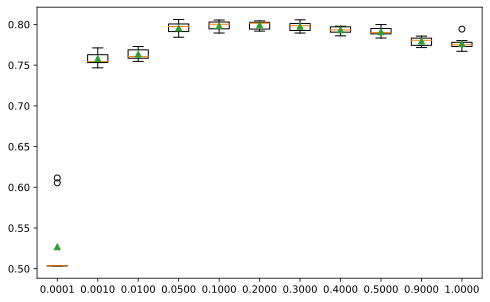

In [101]:
models = get_models_learning_rate()
evaluate(models)

>1 0.780 (0.791) (0.006)
>2 0.797 (0.806) (0.006)
>3 0.799 (0.805) (0.005)
>4 0.802 (0.811) (0.006)
>5 0.802 (0.808) (0.003)
>6 0.800 (0.807) (0.004)
>7 0.797 (0.805) (0.004)
>8 0.792 (0.803) (0.005)
>9 0.790 (0.800) (0.006)
>10 0.788 (0.796) (0.006)


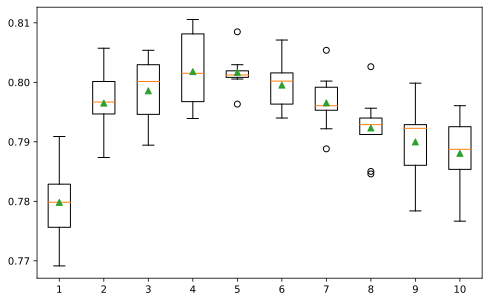

In [102]:
models = get_models_max_depth()
evaluate(models)

>deviance 0.799 (0.805) (0.005)
>exponential 0.798 (0.805) (0.005)


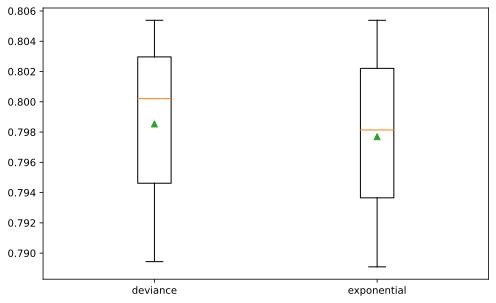

In [103]:
models = get_models_loss()
evaluate(models)

>friedman_mse 0.800 (0.827) (0.011)
>squared_error 0.800 (0.827) (0.011)


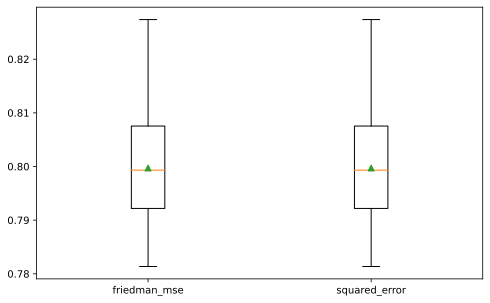

In [83]:
models = get_models_criterion()
evaluate(models)

In [116]:
estimators = {
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'SVC' : SVC(),
    'GaussianNB' : GaussianNB(),
    'RandomForestClassifier' : RandomForestClassifier(random_state=1),
    'ExtraTreesClassifier' : ExtraTreesClassifier(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=1),
    'AdaBoostClassifier' : AdaBoostClassifier(),
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier(),
    'BaggingClassifier' : BaggingClassifier(HistGradientBoostingClassifier())
}



for estimator_name, estimator_object in estimators.items():
    
    kfold = KFold(n_splits=3, random_state=1, shuffle=True)
    scores = cross_val_score(estimator = estimator_object, X = train_df, y = transported, cv = kfold)
    
    print(f'{estimator_name:>30}: ' +
          f'mean accuracy ={scores.mean():.2%};' +
          f' standard deviation ={scores.std():.2%}; '
         )

          KNeighborsClassifier: mean accuracy =76.14%; standard deviation =0.50%; 
                           SVC: mean accuracy =78.58%; standard deviation =0.77%; 
                    GaussianNB: mean accuracy =72.00%; standard deviation =0.72%; 
        RandomForestClassifier: mean accuracy =79.03%; standard deviation =0.82%; 
          ExtraTreesClassifier: mean accuracy =78.13%; standard deviation =0.62%; 
        DecisionTreeClassifier: mean accuracy =73.25%; standard deviation =0.50%; 
    GradientBoostingClassifier: mean accuracy =79.97%; standard deviation =0.31%; 
            AdaBoostClassifier: mean accuracy =78.78%; standard deviation =0.17%; 
HistGradientBoostingClassifier: mean accuracy =80.03%; standard deviation =0.48%; 
             BaggingClassifier: mean accuracy =80.41%; standard deviation =0.61%; 


In [ ]:
# Feature importances using MDI

model = RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=8,
                           n_estimators=600, random_state=1)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

importances = model.feature_importances_
feature_names = train_df.columns
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
plot_feature_importance(GradientBoostingClassifier(), train_df, transported)

In [ ]:
train_df.drop(['GroupSize'], axis=1, inplace=True)
test_df.drop(['GroupSize'], axis=1, inplace=True)

In [ ]:
boosting_type='goss',objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.01, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       max_bin = 55,
                                                       min_data_in_leaf = 71, 
                                                       bagging_fraction = 0.6,
                                                       feature_fraction = 0.8,
                                                       reg_alpha=1e-05,
                                                       reg_lambda=1e-05, min_split_gain=0.2)

In [ ]:
model = GradientBoostingClassifier(n_estimators=97, max_features='auto', learning_rate=0.1, 
                                                              max_depth=5, random_state=0)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

## Score: 0.80243

In [ ]:
submission_df['Transported'] = prediction
submission_df['Transported'] = submission_df['Transported'].apply(lambda r: True if r == 1 else False)

submission_df.to_csv('006_LightGBM_fit.csv', index=False)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from numpy import mean
from numpy import std

## Настройка параметров модели

In [ ]:
import lightgbm as lgb

In [ ]:
lgb.LGBMClassifier

In [ ]:
# 'max_depth': 5     # Поскольку набор данных не очень большой, выбрано умеренное значение, 
#                    # на самом деле 4-10 не имеет значения.
        
# 'num_leaves': 30   # Поскольку lightGBM растет по левому краю, официальное утверждение меньше 2 ^ max_depth
    
# 'subsample'/'bagging_fraction':0.8           # Выборка данных
# 'colsample_bytree'/'feature_fraction': 0.8   # Выборка функций
    
    
# Используйте встроенный параметр настройки cv n_estimators lgb, обратите внимание, 
# что скорость обучения лучше всего установить на 0,1 при настройке параметров, чтобы ускорить скорость сходимости    

In [ ]:
params = {    
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'nthread':4,
          'learning_rate':0.1,# Для ускорения сходимости
          'num_leaves':30, 
          'max_depth': 5,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
    }

In [ ]:
data_train = lgb.Dataset(train_df, transported)
cv_results = lgb.cv(params, data_train, 
                    num_boost_round=1000, 
                    nfold=5, 
                    stratified=False, 
                    shuffle=True, 
                    metrics='auc',
                    early_stopping_rounds=50,
                    seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

# Определите max_depth и num_leaves:

> ***num_leaves***  🔗︎, default = 31, type = int, aliases: **`num_leaf`, ```max_leaves```, ```max_leaf```,                                                    ```max_leaf_nodes```**, I'm constraints: 1 < num_leaves <= 131072 -
max number of leaves in one tree

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
# Используйте Регрессор или Классификатор
# Параметр metrics не может = 'roc_auc', потому что кривая roc используется для оценки двух классификаций

params_test1={'max_depth': range(3,8,1), 'num_leaves':range(5, 100, 5)}
              
gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=6, 
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                                                   param_grid = params_test1, cv=5,n_jobs=-1)
gsearch1.fit(train_df, transported)
# Четко используйте Регрессор или Классификатор
#regressor Параметр проблемы не может добавить scoring = 'roc_auc', потому что кривая roc используется для оценки двух классификаций
print(gsearch1.best_params_)
print(gsearch1.best_score_)

## Определите min_data_in_leaf и max_bin:

>**min_data_in_leaf** 🔗︎, default = 20, type = int, aliases: **`min_data_per_leaf, min_data, min_child_samples, min_samples_leaf`**, constraints: min_data_in_leaf >= 0
minimal number of data in one leaf. Can be used to deal with over-fitting
**Note**: this is an approximation based on the Hessian, so occasionally you may observe splits which produce leaf nodes that have less than this many observations

In [ ]:
params_test2={'max_bin': range(5,256,10), 'min_data_in_leaf':range(1,102,10)}

gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                                         param_grid = params_test2, cv=5,n_jobs=-1)
gsearch2.fit(train_df, transported)
print(gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_)

## Определите feature_fraction, bagging_fraction, bagging_freq

> **feature_fraction** 🔗︎, default = 1.0, type = double, aliases: **`sub_feature`, `colsample_bytree`**, constraints: 0.0 < feature_fraction <= 1.0
LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
can be used to speed up training
can be used to deal with over-fitting

> **bagging_fraction** 🔗︎, default = 1.0, type = double, aliases: **`sub_row`, `subsample`, `bagging`**, constraints: 0.0 < bagging_fraction <= 1.0
like feature_fraction, but this will randomly select part of data without resampling
can be used to speed up training
can be used to deal with over-fitting
Note: to enable bagging, bagging_freq should be set to a non zero value as well

> **bagging_freq** 🔗︎, default = 0, type = int, aliases: **`subsample_freq`**
frequency for bagging
0 means disable bagging; k means perform bagging at every k iteration. Every k-th iteration, LightGBM will randomly select bagging_fraction * 100 % of the data to use for the next k iterations
Note: to enable bagging, bagging_fraction should be set to value smaller than 1.0 as well

In [ ]:
params_test3={'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,81,10)
}
gsearch3 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       max_bin = 55,
                                                       min_data_in_leaf = 71, 
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                       param_grid = params_test3, cv=5,n_jobs=-1)

gsearch3.fit(train_df, transported)
print(gsearch3.best_params_, gsearch3.best_score_)

## Определите lambda_l1 и lambda_l2

> **lambda_l1** 🔗︎, default = 0.0, type = double, aliases: **`reg_alpha, l1_regularization'**, constraints: lambda_l1 >= 0.0
L1 regularization
> **lambda_l2** 🔗︎, default = 0.0, type = double, aliases: **`reg_lambda, lambda, l2_regularization`**, constraints: lambda_l2 >= 0.0
L2 regularization


In [ ]:
params_test4={'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
            }

gsearch4 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       max_bin = 55,
                                                       min_data_in_leaf = 71, 
                                                       bagging_fraction = 0.6,
                                                       feature_fraction = 0.8), 
                       param_grid = params_test4, cv=5,n_jobs=-1)

gsearch4.fit(train_df, transported)
print(gsearch4.best_params_, gsearch4.best_score_)


## ОК min_split_gain


> **min_gain_to_split** 🔗︎, default = 0.0, type = double, aliases: **`min_split_gain`**, constraints: min_gain_to_split >= 0.0
the minimal gain to perform split
can be used to speed up training

In [ ]:
params_test5={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

gsearch5 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       max_bin = 55,
                                                       min_data_in_leaf = 71, 
                                                       bagging_fraction = 0.6,
                                                       feature_fraction = 0.8,
                                                       reg_alpha=1e-05,
                                                       reg_lambda=1e-05), 
                       param_grid = params_test5, cv=5,n_jobs=-1)

gsearch5.fit(train_df, transported)
print(gsearch5.best_params_, gsearch5.best_score_)


In [ ]:
lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1, 
                                                       n_estimators=97, 
                                                       max_depth=5,
                                                       num_leaves = 20,
                                                       max_bin = 55,
                                                       min_data_in_leaf = 71, 
                                                       bagging_fraction = 0.6,
                                                       feature_fraction = 0.8,
                                                       reg_alpha=1e-05,
                                                       reg_lambda=1e-05, min_split_gain=0.0)
                  

In [ ]:
data_train = lgb.Dataset(train_df, transported)

params = {  
            'boosting_type' :'goss',
            'objective' :'binary',
            'metrics'  : 'auc',
            'learning_rate' : 0.0001, 
            'n_estimators' : 97, 
            'max_depth' : 15,
            'num_leaves' : 200,
            'max_bin' : 555,
            'min_data_in_leaf' : 71, 
            'bagging_fraction' : 0.6,
            'feature_fraction' : 0.8,
            'reg_alpha' : 1e-05,
            'reg_lambda' : 1e-05,
            'min_split_gain' : 0.0
           }

cv_results = lgb.cv(params, data_train, 
                    num_boost_round=1000, 
                    nfold=5, 
                    stratified=False, 
                    shuffle=True, 
                    metrics='auc',
                    early_stopping_rounds=50,
                    seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

In [121]:
model = BaggingClassifier(HistGradientBoostingClassifier())

In [122]:
model.fit(train_df, transported)  
prediction = model.predict(test_df)  

In [123]:
submission_df['Transported'] = prediction
submission_df['Transported'] = submission_df['Transported'].apply(lambda r: True if r == 1 else False)

submission_df.to_csv('001_BaggingClassifiert_HistGradientBoostingClassifier.csv', index=False)

NameError: name 'submission_df' is not defined

In [ ]:
model.f